<a href="https://colab.research.google.com/github/biga-bojana/formality-evaluation-task/blob/main/formality_evaluation_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q datasets pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==1

In [3]:
from datasets import load_dataset
import pandas as pd
import random

# Load Informal Data

# DailyDialog
daily_dialog = load_dataset("daily_dialog", split="train", trust_remote_code=True)
daily_texts = []
for dialog in daily_dialog["dialog"]:
    daily_texts.extend(dialog)
random.shuffle(daily_texts)
informal_dialogs = daily_texts[:40]

# TweetEval: social media language
tweet_eval = load_dataset("tweet_eval", "emotion", split="train")
tweet_texts = tweet_eval["text"]
random.shuffle(tweet_texts)
informal_tweets = tweet_texts[:40]

# Combine both
informal_texts = informal_dialogs + informal_tweets
df_informal = pd.DataFrame({
    "text": informal_texts,
    "label": ["informal"] * len(informal_texts)
})

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.27k [00:00<?, ?B/s]

daily_dialog.py:   0%|          | 0.00/4.85k [00:00<?, ?B/s]

The repository for daily_dialog contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/daily_dialog.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/11118 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/233k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/105k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/28.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3257 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1421 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/374 [00:00<?, ? examples/s]

In [3]:
# Load Enron from direct .parquet link
enron_url = "https://huggingface.co/datasets/amanneo/enron-mail-corpus-mini/resolve/main/data/train-00000-of-00001-014f331c4b4820b4.parquet"
df_enron = pd.read_parquet(enron_url)

# Take first 80 for formal class
df_formal = pd.DataFrame({
    "text": df_enron["text"].tolist()[:80],
    "label": ["formal"] * 80
})


In [4]:
# Combine and shuffle
df_combined = pd.concat([df_formal, df_informal], ignore_index=True)
df_combined = df_combined.sample(frac=1).reset_index(drop=True)

# Preview the dataset
df_combined.head()


,text,label
0,You are proof that good things come to those w...,formal
1,I’ve got a feeling this is only the beginning ...,formal
2,@user when you click over and over again for a...,informal
3,I seem to alternate between 'sleep-full' and s...,informal
4,"Since this will be our first baby, I am way to...",formal


In [5]:
from transformers import pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define evaluation function
def evaluate_model(model_name_or_path, texts, labels, label_map=None, title_suffix=""):
    clf = pipeline("text-classification", model=model_name_or_path)

    predictions = []
    for text in texts:
        try:
            output = clf(text)[0]
            label = output['label'].lower()
            if label_map:
                label = label_map.get(label, label)
            predictions.append(label)
        except Exception as e:
            print(f"Failed on input: {text[:30]}... Error: {e}")
            predictions.append("error")

    print(f"\nEvaluation for model: {model_name_or_path}")
    print("Accuracy:", accuracy_score(labels, predictions))
    print("\nClassification report:\n", classification_report(labels, predictions))

    cm = confusion_matrix(labels, predictions, labels=sorted(set(labels)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=sorted(set(labels)), yticklabels=sorted(set(labels)))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion matrix: {title_suffix or model_name_or_path}")
    plt.show()

    return predictions


In [1]:
texts = df_combined["text"].tolist()
labels = df_combined["label"].tolist()



NameError: name 'df_combined' is not defined

In [7]:
!pip install transformers

In [8]:
from transformers import pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_with_neutral_remap(model_name_or_path, texts, labels, title_suffix=""):
    clf = pipeline("text-classification", model=model_name_or_path)

    raw_preds = []
    for text in texts:
        try:
            output = clf(text)[0]
            label = output['label'].lower()
            if label == "neutral":
                label = "formal"  # remap neutral → formal
            raw_preds.append(label)
        except Exception as e:
            print(f"Failed on input: {text[:30]}... Error: {e}")
            raw_preds.append("error")

    print(f"\nEvaluation for model: {model_name_or_path} (Neutral → Formal)")
    print("Accuracy:", accuracy_score(labels, raw_preds))
    print("\n Classification report:\n", classification_report(labels, raw_preds))

    cm = confusion_matrix(labels, raw_preds, labels=sorted(set(labels)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=sorted(set(labels)), yticklabels=sorted(set(labels)))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion matrix: {title_suffix or model_name_or_path} (Neutral → Formal)")
    plt.show()

    return raw_preds


config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Device set to use cpu



📊 Evaluation for model: LenDigLearn/formality-classifier-mdeberta-v3-base (Neutral → Formal)
✅ Accuracy: 0.875

📋 Classification Report:
               precision    recall  f1-score   support

      formal       0.80      1.00      0.89        80
    informal       1.00      0.75      0.86        80

    accuracy                           0.88       160
   macro avg       0.90      0.88      0.87       160
weighted avg       0.90      0.88      0.87       160



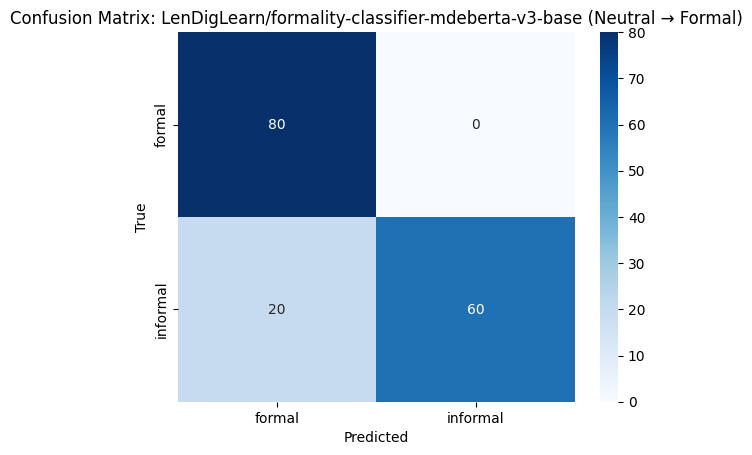

In [9]:
preds_deberta = evaluate_model_with_neutral_remap(
    "LenDigLearn/formality-classifier-mdeberta-v3-base",
    df_combined["text"].tolist(),
    df_combined["label"].tolist()
)
